### CNN for Assamese characters

The data for the Assamese characters have been taken from this [UCI respository](https://archive.ics.uci.edu/ml/datasets/Online+Handwritten+Assamese+Characters+Dataset#). There are about 8326 images corresponding to various letters, combined letters and numbers. The original data has not contain images but instead consist of lines and strokes used for writing each alphabet. This will not be useful for character recognition and thus the dataset has been converetd into images and categorised train and test sets which will make it easier to use Keras for classification. 


We will be using Keras in this notebook as it is the easiest to implement and test a neural network.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
import tensorflow.keras.utils

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, array_to_img, img_to_array


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import metrics
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(50, 50, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Dropout(0.25))

# the model so far outputs 3D feature maps (height, width, features)

# dense layer
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(183, activation = 'softmax'))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In order to have nicer convergence it will be best to employ a learning rate that will decrease with epoch. At higher epoch the loss does not reduce significantly and we can explore the loss region more efficiently by reducing the learning rate.

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

### Mount Google Drive

Dataset must be loaded from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Get the path for the dataset
root_path = "/content/gdrive/MyDrive/final_year_project/new_data_set"

# training data set
train_data_set_path = root_path + '/data/train'

# testing data set
test_data_set_path = root_path + '/data/test'

# predict data set
predict_data_set_path = root_path + '/data/predict'

# filepath to the model
model_path = "/content/gdrive/MyDrive/final_year_project/new_data_set/new_model"

In [ ]:
batch_size = 30

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=False)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_data_set_path,  # this is the target directory
        target_size=(50, 50),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        test_data_set_path,
        target_size=(50, 50),
        batch_size=batch_size,
        class_mode='categorical')

model.summary()

Found 6563 images belonging to 183 classes.
Found 1649 images belonging to 183 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                  

## Model Visualiser

We are using visual keras to visualise the model.

In [ ]:
!pip install visualkeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 19.9 MB/s eta 0:00:00


In [ ]:
import visualkeras
from keras.utils.vis_utils import plot_model

### Generate Model Plot of all the layers

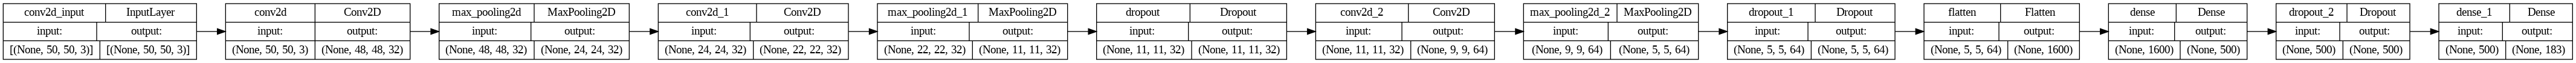

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir="LR")

### Generate Model visualisation

In [ ]:
visualkeras.layered_view(model, legend=True, spacing=20)

NameError: ignored

## Model Checkpoint

Here, we setup early stopping and save the best model in google drive.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_checkpoint = ModelCheckpoint(filepath= model_path + "/bestmodel10.h5",
                                   monitor="accuracy",
                                   verbose=1,
                                   save_best_only=True)

early_stopping = EarlyStopping(monitor= "accuracy",
                               min_delta=0.01,
                               patience = 7,
                               verbose = 1 )

callbacks_list = [model_checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=130,
        validation_data=validation_generator,
        validation_steps=1000  // batch_size,
        callbacks=callbacks_list )
# model.save_weights('first_try.h5')


<ipython-input-8-6245dcd8ca6e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/130
66/66 [==============================] - ETA: 0s - loss: 5.2254 - accuracy: 0.0041 
Epoch 1: accuracy improved from -inf to 0.00405, saving model to /content/gdrive/MyDrive/final_year_project/new_data_set/new_model/bestmodel10.h5
66/66 [==============================] - 1717s 26s/step - loss: 5.2254 - accuracy: 0.0041 - val_loss: 5.2094 - val_accuracy: 0.0101
Epoch 2/130
66/66 [==============================] - ETA: 0s - loss: 5.2099 - accuracy: 0.0071 
Epoch 2: accuracy improved from 0.00405 to 0.00707, saving model to /content/gdrive/MyDrive/final_year_project/new_data_set/new_model/bestmodel10.h5
66/66 [==============================] - 1041s 16s/step - loss: 5.2099 - accuracy: 0.0071 - val_loss: 5.2053 - val_accuracy: 0.0081
Epoch 3/130
66/66 [==============================] - ETA: 0s - loss: 5.1682 - accuracy: 0.0142
Epoch 3: accuracy improved from 0.00707 to 0.01419, saving model to /content/gdrive/MyDrive/final_year_project/new_data_set/new_model/bestmodel10.h5
66/66

# Save history using Pickle

Save the training history of the model using pickle library

In [ ]:
import pickle

with open(model_path + '/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print(history.history.keys)

<built-in method keys of dict object at 0x7f4cfc320f80>


In [ ]:
# load history
import pickle

with open(model_path + '/trainHistoryDict', "rb") as file_pi:
    history2 = pickle.load(file_pi)


print(history2)

{'loss': [5.225444316864014, 5.2098541259765625, 5.16820764541626, 4.937236785888672, 4.362488269805908, 3.8344273567199707, 3.3929691314697266, 2.986048698425293, 2.7807016372680664, 2.5602827072143555, 2.3550028800964355, 2.212635040283203, 1.9974974393844604, 1.8880772590637207, 1.7913705110549927, 1.6796588897705078, 1.5792986154556274, 1.551922082901001, 1.4292881488800049, 1.412226676940918, 1.3522963523864746, 1.3001289367675781, 1.2392830848693848, 1.234419822692871, 1.1962273120880127, 1.1286696195602417, 1.1137237548828125, 1.0655241012573242, 1.0394299030303955, 0.9872453808784485, 0.9764853119850159, 0.9490759372711182, 0.9450893402099609, 0.8807371258735657, 0.894146740436554, 0.8493853211402893, 0.8689977526664734, 0.845488429069519, 0.8205539584159851, 0.7845937013626099, 0.8344781994819641, 0.8372837901115417, 0.721235454082489, 0.7644146680831909, 0.7022502422332764, 0.7414051294326782, 0.7359123229980469, 0.6785934567451477, 0.6645036339759827, 0.6177360415458679, 0.6

In [ ]:
# import all the metrics score calculator

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(validation_generator, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)
# reduce to 1d array
print(yhat_classes)
yhat_probs = yhat_probs[:, 0]
print(yhat_probs)
# yhat_classes = yhat_classes[:, 0]

[ 33 137 108 ...   0 114 113]
[9.2224362e-13 2.4122581e-11 1.6866012e-11 ... 9.8521936e-01 3.9098943e-11
 1.1279975e-11]


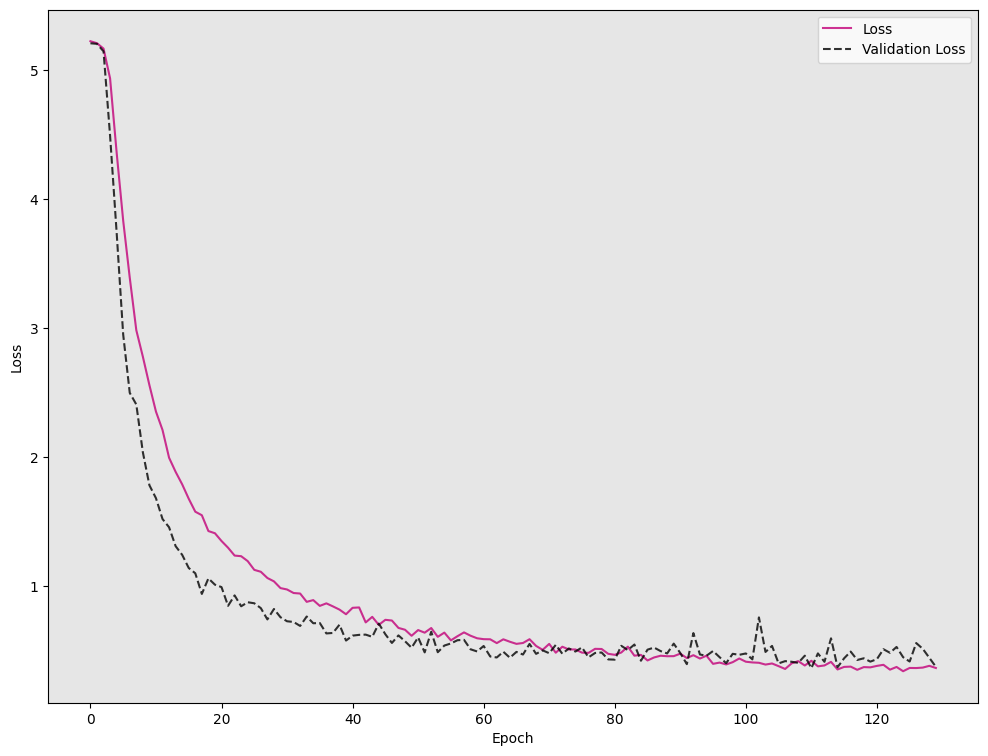

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,9))
ax.plot(history['loss'], '-', color = 'xkcd:magenta', label = 'Loss', alpha = 0.8)
ax.plot(history['val_loss'], '--', color = 'xkcd:black', label = 'Validation Loss', alpha = 0.8)
ax.legend(loc = 'best')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_facecolor('0.9')

In [ ]:
print(history2.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


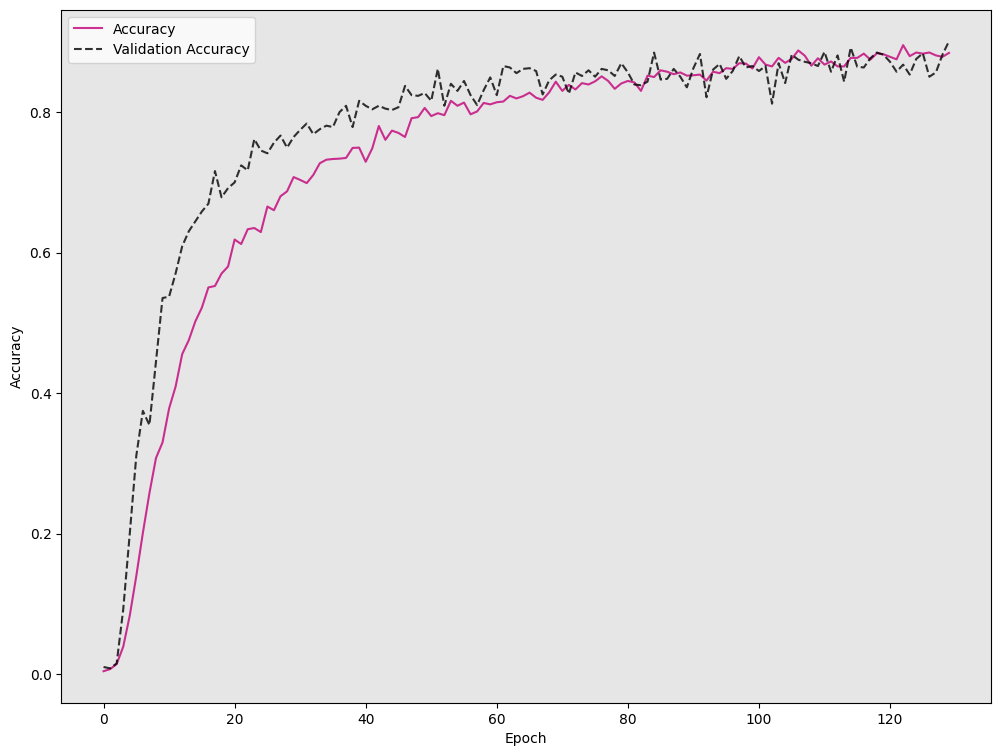

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,9))
ax.plot(history2['accuracy'], '-', color = 'xkcd:magenta', label = 'Accuracy', alpha = 0.8)
ax.plot(history2['val_accuracy'], '--', color = 'xkcd:black', label = 'Validation Accuracy', alpha = 0.8)
ax.legend(loc = 'best')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_facecolor('0.9')

# Get all the graphs

1. Training Loss v/s Val Loss
2. Training Accuracy v/s Val Accuracy
3. Confusion Matrix
4. Sensitivity
5. Precision
6. F1 Score
7. Specificity
8. Accuracy

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)

# Load Earlier Model

Load earlier model and check for all the graphs F1 score

In [ ]:
from keras.models import load_model

model = load_model(model_path + "/bestmodel10.h5")

## Accuracy graph


In [ ]:
predict_generator = test_datagen.flow_from_directory(
                test_data_set_path,
                target_size=(50, 50),
                batch_size=1650,
                class_mode='categorical', shuffle = False)
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Predict the output
y_pred = model.predict(predict_generator)
#y_pred_classes
y_pred_classes = np.argmax(y_pred, axis = 1)

#y true values

y_true = validation_generator.classes

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

Found 1649 images belonging to 183 classes.
1/1 [==============================] - 3s 3s/step
[[ 2  2  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  0  0  5]]


In [ ]:
accuracy = cm.trace()/cm.sum()

In [ ]:
print('The overall accuracy is: {}% '.format(accuracy*100))

The overall accuracy is: 87.08308065494239% 


In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_classes, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_classes, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.870831
Precision: 0.894121
Recall: 0.870831
F1 score: 0.870175


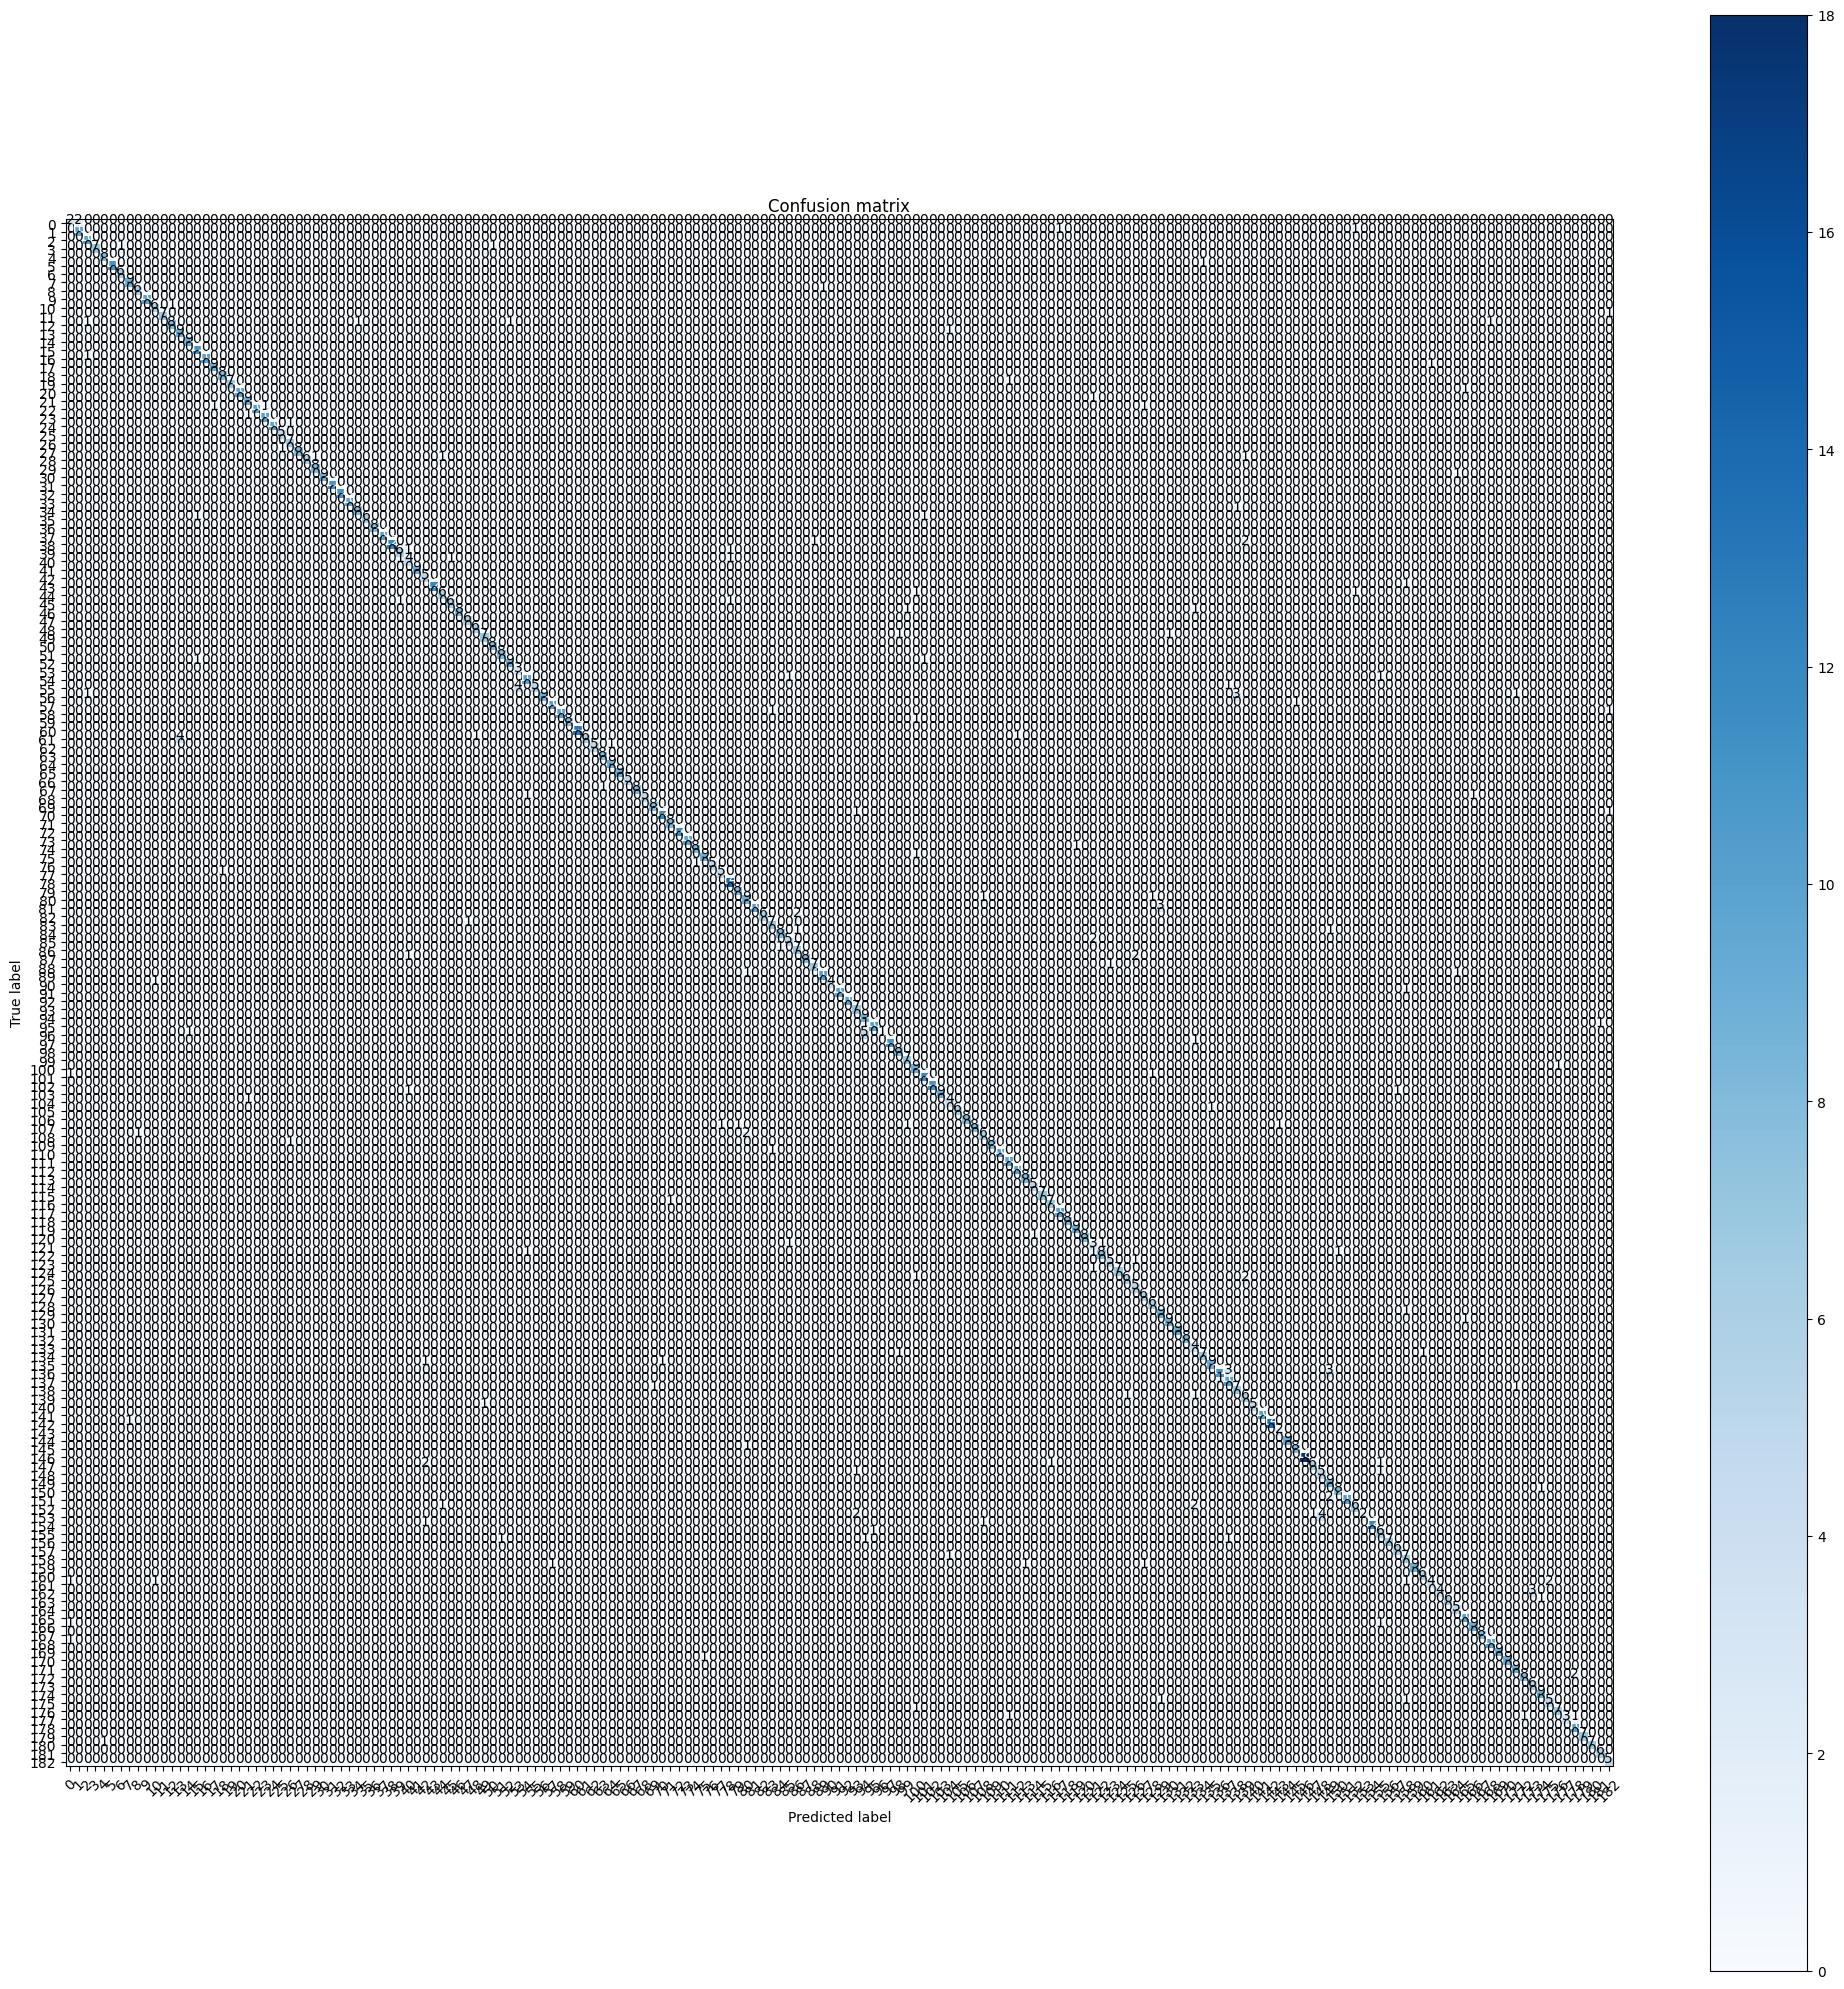

In [ ]:
plt.figure(figsize = (20, 20))
plot_confusion_matrix(cm, classes = range(183))

I am plotting just the first 50 of the classes in order to demonstrate how the confusion matrix looks like.

In [ ]:
x = train_generator.class_indices

In [ ]:
# Install python resize image
!pip install python-resize-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1/1 [==============================] - 0s 87ms/step
<class 'numpy.ndarray'>
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
['A', 'AA', 'AE', 'AJA', 'ANSR', 'ATH', 'AYA', 'BA', 'BB', 'BD', 'BHA', 'BHM', 'BHR', 'BJ', 'BL', 'BRR', 'BXG', 'CA', 'CARI', 'CAY', 'CBN', 'CC', 'CCA', 'CCC', 'DA', 'DB', 'DD', 'DDH', 'DG', '

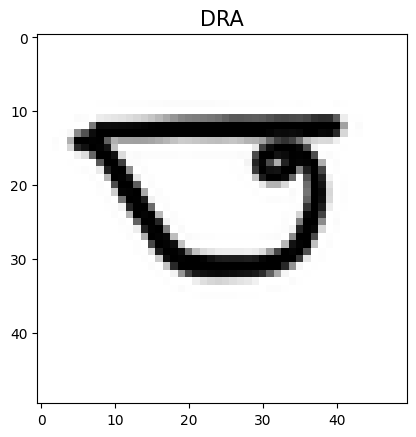

In [ ]:
from resizeimage import resizeimage
def predict_new_image(path):
        test1 = load_img(path)
        test2 = resizeimage.resize_contain(test1, [50,50]).convert('RGB')
        test = img_to_array(test2)
        test = np.expand_dims(test, axis = 0)
        result = model.predict(test)
        print(type(result))
        for value in result:
          for value2 in value:
            print(value2)
        x = train_generator.class_indices
        all_label = list(x.keys())
        print(all_label)
        plt.figure()
        plt.clf()
        plt.imshow(test2, cmap = 'Greys')
        plt.title(all_label[result.argmax()], fontsize = 15)

predict_new_image('/content/gdrive/MyDrive/final_year_project/new_data_set/data/predict/predict_10.jpg')

In [ ]:
from keras import models



1/1 [==============================] - 0s 85ms/step


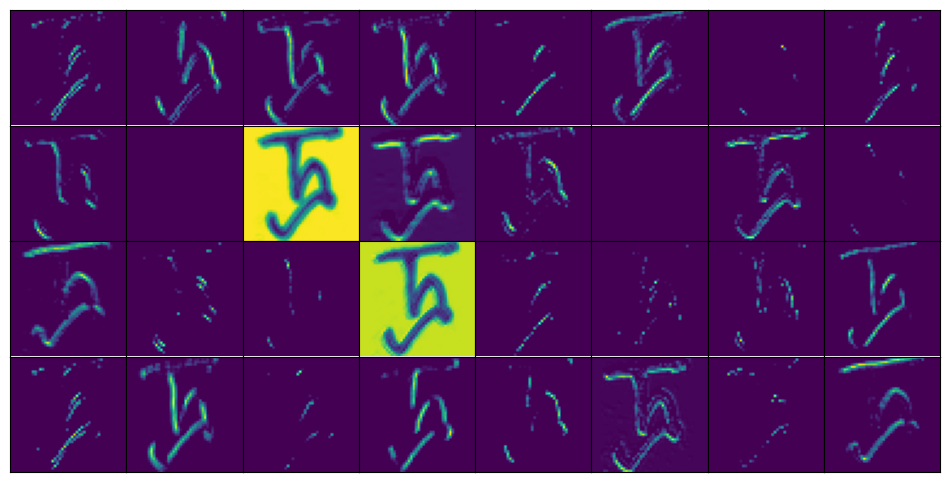

In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
test1 = load_img('/content/gdrive/MyDrive/final_year_project/new_data_set/data/predict/predict_8.jpg')
test2 = resizeimage.resize_contain(test1, [50,50]).convert('RGB')
test = img_to_array(test2)
test = np.expand_dims(test, axis = 0)
activations = activation_model.predict(test)

first_layer_activation = activations[0]
fig = plt.figure(figsize = (12, 6))
for i in range(first_layer_activation.shape[3]):
    ax = plt.subplot(4, 8, i+1)
    ax.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
fig.subplots_adjust(wspace=0, hspace=0)



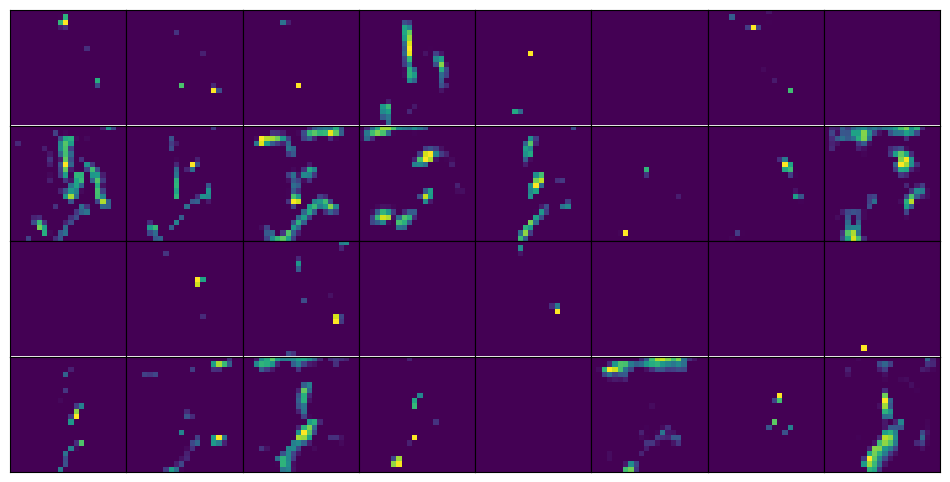

In [ ]:
second_layer_activation = activations[2]
fig = plt.figure(figsize = (12, 6))
for i in range(second_layer_activation.shape[3]):
    ax = plt.subplot(4, 8, i+1)
    ax.imshow(second_layer_activation[0, :, :, i], cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
model.layers

In [ ]:
activations[5].shape

(1, 9, 9, 64)

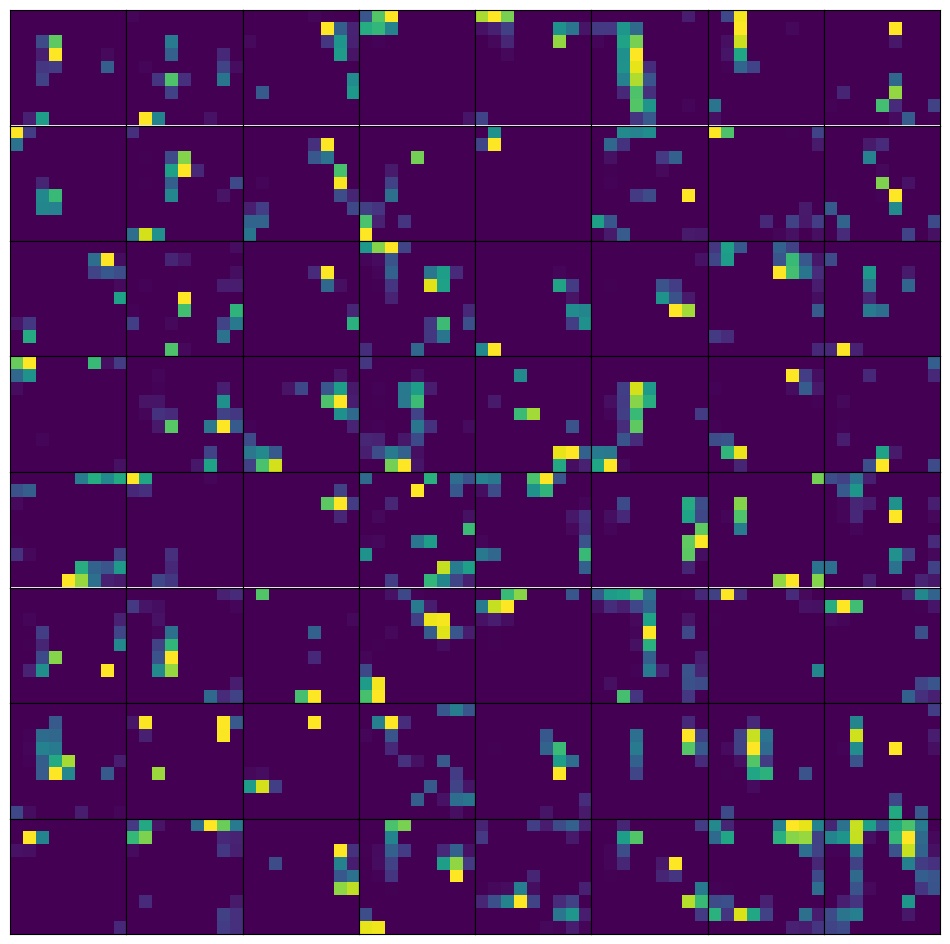

In [ ]:
third_conv_activation = activations[5]
fig = plt.figure(figsize = (12, 12))
for i in range(third_conv_activation.shape[3]):
    ax = plt.subplot(8, 8, i+1)
    ax.imshow(third_conv_activation[0, :, :, i], cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
fig.subplots_adjust(wspace=0, hspace=0)

I have displayed the outputs of the various Convolution layers to get an idea of how the various layers look like. We can see how the various filters look like. This filters as we can see helps us various features which in turn are used for classification.